In [1]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

import torch

from monai.metrics import DiceMetric
from monai.networks.nets import SegResNet
from monai.inferers import sliding_window_inference

from monai.inferers import Inferer, SlidingWindowInferer

from monai.transforms import (
    Compose,
    Activationsd,
    AsDiscreted,
    AsDiscrete,
    EnsureChannelFirstd,
    EnsureTyped,
    GaussianSmoothd,
    KeepLargestConnectedComponent,
    LoadImaged,
    NormalizeIntensityd,
    Orientationd,
    ScaleIntensityd,
    Spacingd,
)
from monai.data import (
    ThreadDataLoader, Dataset, DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
    set_track_meta,
)

In [2]:
device = torch.device("cuda:0")

### Datasets & path

In [3]:
images_path = "/home/fehrdelt/data_ssd/monai_label/final_dataset_brain_extraction/fixed_distribution/test_dataset/"
labels_path = images_path+"labels/final/"

test_images_path = []
test_labels_path = []

for file in os.listdir(images_path):
    if file.endswith(".nii.gz"):
        test_images_path.append(images_path+file)
        test_labels_path.append(labels_path+file)

### Transformations & augmentations

In [4]:
target_spacing=(1.0, 1.0, 1.0)

In [5]:
test_transforms = Compose(
    [
        LoadImaged(keys=("image", "label")),
        EnsureTyped(keys=("image", "label"), device=device),
        EnsureChannelFirstd(keys=("image", "label")),
        Orientationd(keys=("image", "label"), axcodes="RAS"),
        Spacingd(keys=("image", "label"), pixdim=target_spacing, allow_missing_keys=True),
        NormalizeIntensityd(keys="image", nonzero=True),
        GaussianSmoothd(keys="image", sigma=0.4),
        ScaleIntensityd(keys="image", minv=-1.0, maxv=1.0),
    ])

test_dict_ds = [{"image": image_name, "label": label_name} for image_name,label_name in zip(test_images_path, test_labels_path)]
test_ds = Dataset(data=test_dict_ds, transform=test_transforms)

test_loader = DataLoader(test_ds, batch_size=1)# num_workers=4)

In [6]:
post_label = AsDiscrete(to_onehot=2)
post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2), KeepLargestConnectedComponent()])

### Model configuration

In [7]:
max_epochs = 1500
val_interval = 5
VAL_AMP = True


# standard PyTorch program style: create SegResNet, DiceLoss and Adam optimizer
device = torch.device("cuda:0")

model = SegResNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,  # labels plus background,
    init_filters=32,
    blocks_down=(1, 2, 2, 4),
    blocks_up=(1, 1, 1),
    dropout_prob=0.2,
).to(device)



dice_metric_batch = DiceMetric(include_background=False, reduction="mean_batch")


# define inference method
def inference(input):
    def _compute(input):
        return sliding_window_inference(
            inputs=input,
            roi_size=(96, 96, 96),
            sw_batch_size=2,
            predictor=model,
            overlap=0.4,
            padding_mode="replicate",
            mode="gaussian"
        )

    if VAL_AMP:
        with torch.cuda.amp.autocast():
            return _compute(input)
    else:
        return _compute(input)


# use amp to accelerate training
scaler = torch.cuda.amp.GradScaler()
# enable cuDNN benchmark
torch.backends.cudnn.benchmark = True

### Inference on test set

In [8]:
model_folder = "/home/fehrdelt/data_ssd/monai_label/radiology4GIN/model/"

In [9]:
model.load_state_dict(torch.load(os.path.join(model_folder, "segmentation.pt")))

<All keys matched successfully>

In [10]:
dice_metric_batch.reset()

outputs_list = []

model.eval()
with torch.no_grad():
    for test_data in test_loader:
        test_inputs, test_labels = (
            test_data["image"].to(device),
            test_data["label"].to(device),
        )
        with torch.cuda.amp.autocast():
            test_outputs = sliding_window_inference(test_inputs, (96, 96, 96), 4, model)
        
        test_labels_list = decollate_batch(test_labels)
        test_labels_convert = [post_label(test_label_tensor) for test_label_tensor in test_labels_list]
        
        test_outputs_list = decollate_batch(test_outputs)
        test_outputs_convert = [post_pred(test_pred_tensor) for test_pred_tensor in test_outputs_list]
        
        
        outputs_list.append(test_outputs_convert)
        
        
        
        dice_metric_batch(y_pred=test_outputs_convert, y=test_labels_convert)
        
        


    #metric = dice_metric.aggregate()
    #print(metric)
    
    metric_batch = dice_metric_batch.aggregate().item()
    
    print("DICE score on test dataset: ")
    print(metric_batch)

DICE score on test dataset: 
0.967264711856842


### Visualisation

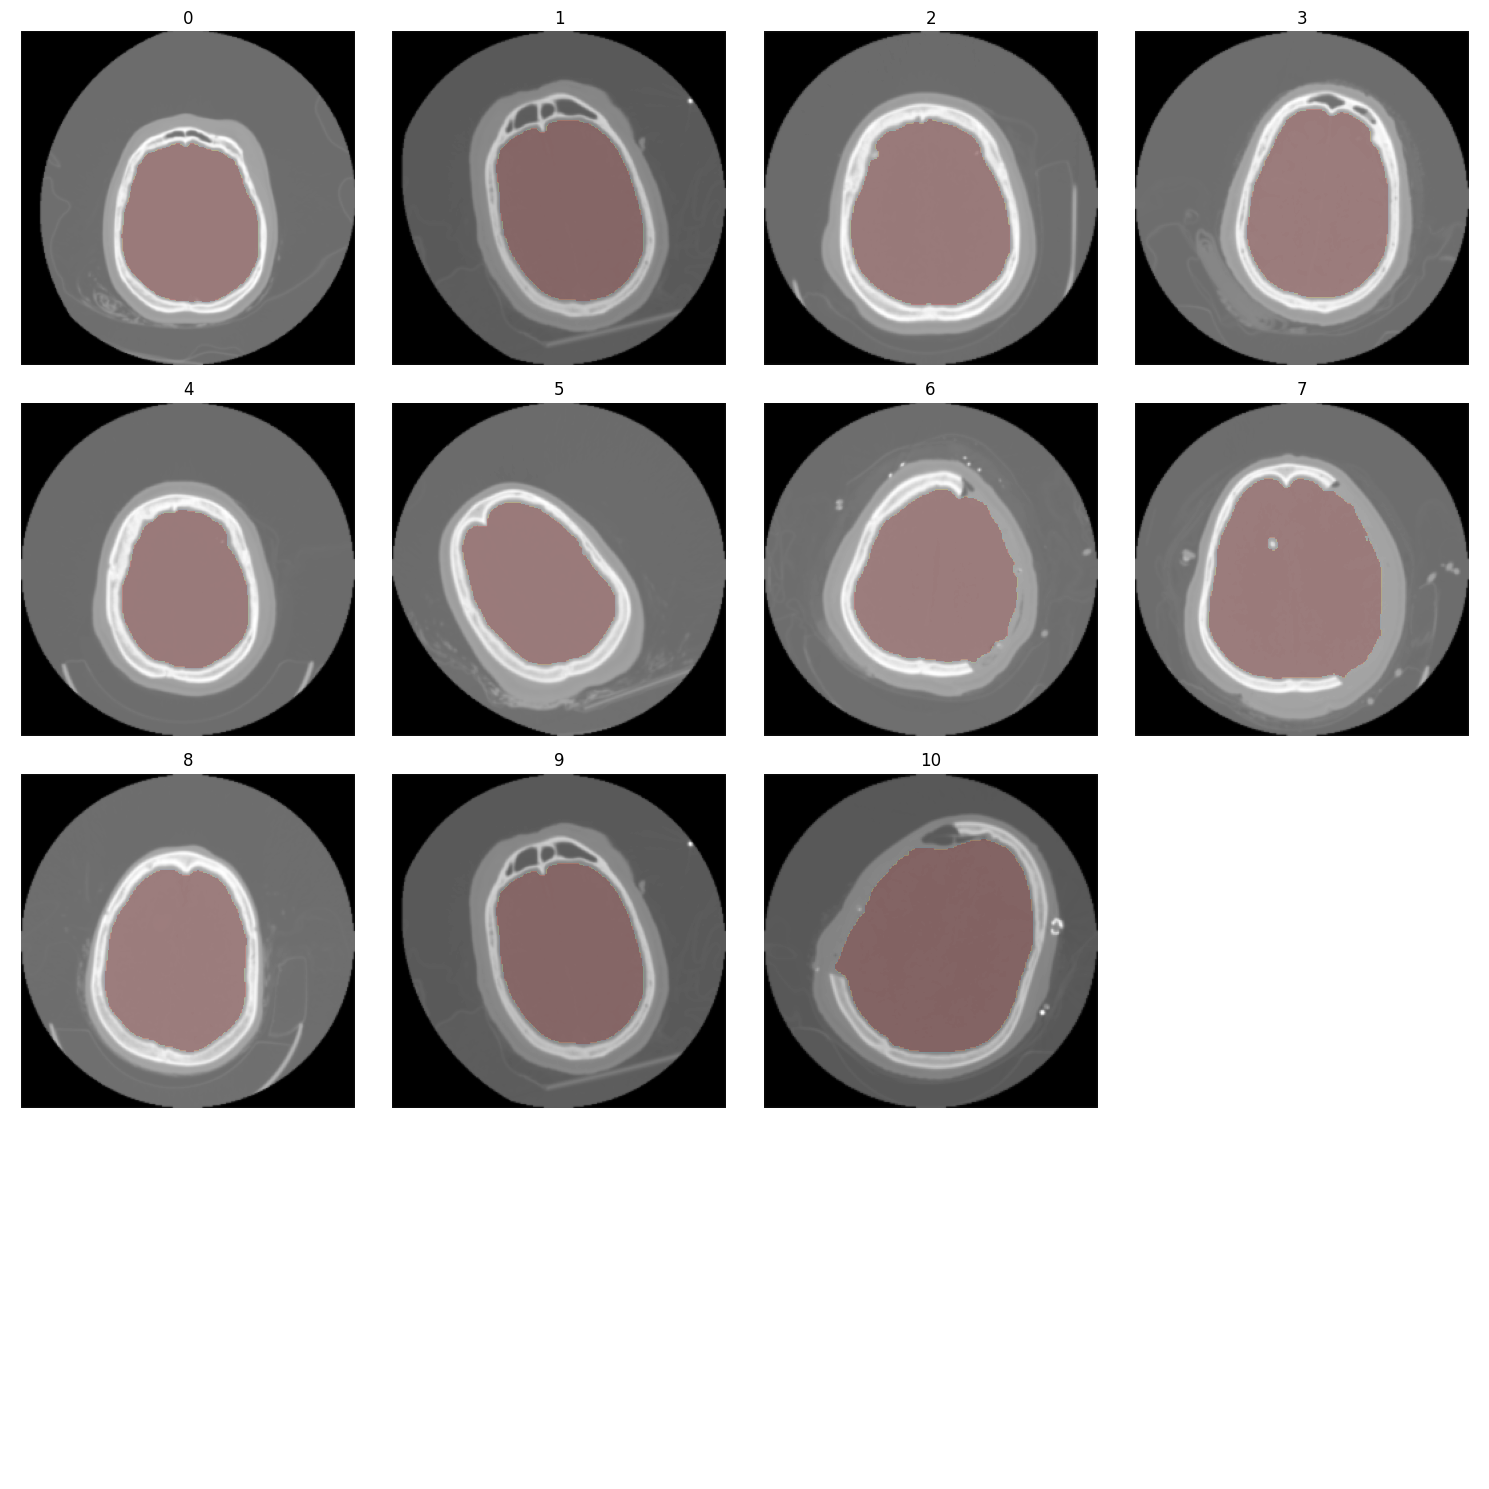

In [19]:
image_slices = []
label_slices = []

for i,data in enumerate(test_ds):
    
    img = data["image"].cpu().numpy()
    image_slices.append(img[0, :, :, img.shape[2]//2])
    
    label = outputs_list[i][0].cpu().numpy()
    #print(label)
    label_slices.append(label[1, :, :, label.shape[2]//2])
    
    
    
# Determine the grid size for plotting
n_images = len(image_slices)
grid_size = int(np.ceil(np.sqrt(n_images)))

# Plot the center slices
fig, axes = plt.subplots(grid_size, grid_size, figsize=(15, 15))
axes = axes.flatten()

for i, slice in enumerate(image_slices):
    axes[i].imshow(slice.T, cmap='gray', origin='lower')
    axes[i].imshow(label_slices[i].T, cmap='jet', origin='lower', alpha=0.25*(label_slices[i].T>0))
    axes[i].axis('off')
    axes[i].set_title(str(i))

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()